In [1]:
# import libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader, Dataset
import numpy as np
import matplotlib.pyplot as plt
import cv2

#!pip install segmentation_models_pytorch
import segmentation_models_pytorch as smp

import albumentations as A
from albumentations.pytorch import ToTensorV2

device = torch.device('cuda' if torch.cuda.is_available() else 'CPU')
print(device)

cuda


In [2]:
# Hyperparameters
n_epochs = 10
learning_rate = 1e-03
batch_size = 8
image_height = 224
image_width = 224
SMOOTH = 1e-6

In [3]:
# define model
model=smp.Unet(in_channels=3, classes=21).to(device)
print(model)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [4]:
# freeze parameters
for i, parents in enumerate(model.children()):
    if i<=1:
        for param in parents.parameters():
            param.requires_grad=False

In [5]:
VOC_COLORMAP = [[0, 0, 0],
                [128, 0, 0], [0, 128, 0], [128, 128, 0],
                [0, 0, 128], [128, 0, 128], [0, 128, 128], [128, 128, 128],
                [64, 0, 0], [192, 0, 0], [64, 128, 0], [192, 128, 0],
                [64, 0, 128], [192, 0, 128], [64, 128, 128], [192, 128, 128],
                [0, 64, 0], [128, 64, 0], [0, 192, 0], [128, 192, 0],
                [0, 64, 128]]

VOC_CLASSES = [
    'background',
    'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'potted plant', 'sheep', 'sofa', 'train', 'tv/monitor']

class VOCDataset(Dataset):
    """
    This class is for the creation of VOC2012 dataset
    """

    def __init__(self, root_path='VOC2012/',
                 type = 'train', image_size=(224, 224), resize_method='resize',transform = None):
        self.root_path = root_path
        self.resize_method = resize_method
        self.type = type
        self.transform = transform

        # define directory where train and val pictures names are stored
        self.names_path = self.root_path + 'ImageSets/Segmentation/'+ self.type +'.txt'

        # define image and labels path
        self.image_path = self.root_path + 'JPEGImages/'
        self.label_path = self.root_path + 'SegmentationClass/'
        self.image_size = image_size

        # define array of picture names, images and labels
        self.names = []
        self.images = []
        self.labels = []

        # parms for converting label pixels to class pixels
        self.colormap2label = self.build_colormap2label()
        self.mode = torchvision.io.image.ImageReadMode.RGB

        # reading file names
        self.read_names()

    def __getitem__(self, index):

        image = cv2.imread(self.image_path + self.names[index] + '.jpg')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = cv2.imread(self.label_path + self.names[index] + '.png')
        label = cv2.cvtColor(label, cv2.COLOR_BGR2RGB)

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=label)
            image = augmentations["image"]
            label = augmentations["mask"]

        label = self.voc_label_indices(label, self.colormap2label)

        return image.to(device), label.to(device)

    def __len__(self):
        return len(self.names)

    def read_names(self):
        """
        Read the filenames of training images and labels into self.names
        """
        f = open(self.names_path, 'r')
        line = None
        while 1:
            line = f.readline().replace('\n','')
            if line is None or len(line) == 0 :
                break
            self.names.append(line)
        f.close()
    def build_colormap2label(self):
        """
        Build an RGB color to label mapping for segmentation.
        """
        colormap2label = torch.zeros(256**3, dtype=torch.long)
        for i, colormap in enumerate(VOC_COLORMAP):
            colormap2label[(colormap[0] * 256 + colormap[1]) * 256 +
                colormap[2]] = i
        return colormap2label


    def voc_label_indices(self,colormap, colormap2label):
        """
        Map an RGB color to a label.
        """
        #colormap = colormap.permute(1, 2, 0).numpy().astype('int32')
        colormap = colormap.numpy().astype('int32')
        idx = ((colormap[:, :, 0] * 256 + colormap[:, :, 1]) * 256 +
            colormap[:, :, 2])
        return colormap2label[idx]


In [6]:
# Define transformers
# use mean=[0.485, 0.456, 0.406] and variance std=[0.229, 0.224, 0.225] for normalization.
train_transform = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            A.Rotate(limit=35, p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.1),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=255.0,
            ),
            ToTensorV2(),
        ],
    )
val_transform = A.Compose(
        [
            A.Resize(height=image_height, width=image_width),
            ToTensorV2()
        ],
)

# get datasets
train_dataset = VOCDataset(image_size=(image_height, image_width),
                           type='train', transform=train_transform)

val_dataset = VOCDataset(image_size=(image_height, image_width),
                         type='val', transform=val_transform)

In [7]:
# create DataLoaders
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

# define loss, model and optimizer
loss_fn = nn.CrossEntropyLoss()
#optimizer = optim.Adam(model.parameters(), lr=learning_rate)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)

In [8]:
def train(n_epochs, data_loader, model, optimizer, loss_fn):
    """
    this function is for training model. one epoch is one call of this function
    """
    print('training start')
    history = {'loss': []}
    for epoch in range(n_epochs):
        for i, (image,target) in enumerate(data_loader):
            # forward propagation
            predictions = model(image)
            loss = loss_fn(predictions, target)
            # backward propagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if i % 10 == 0:
                print(f'Epoch: {epoch}, Iteration: {i}, Loss: {loss}')
            history['loss'].append(loss.item())
        #check_accuracy(val_loader, model)
    return history


training start
Epoch: 0, Iteration: 0, Loss: 2.9807839393615723
Epoch: 0, Iteration: 10, Loss: 2.4304161071777344
Epoch: 0, Iteration: 20, Loss: 1.9166055917739868
Epoch: 0, Iteration: 30, Loss: 1.641831636428833
Epoch: 0, Iteration: 40, Loss: 1.7982573509216309
Epoch: 0, Iteration: 50, Loss: 1.2679991722106934
Epoch: 0, Iteration: 60, Loss: 1.7364933490753174
Epoch: 0, Iteration: 70, Loss: 0.9803065061569214
Epoch: 0, Iteration: 80, Loss: 1.5438790321350098
Epoch: 0, Iteration: 90, Loss: 1.3856964111328125
Epoch: 0, Iteration: 100, Loss: 1.5146057605743408
Epoch: 0, Iteration: 110, Loss: 1.4656904935836792
Epoch: 0, Iteration: 120, Loss: 0.9773935079574585
Epoch: 0, Iteration: 130, Loss: 1.884548306465149
Epoch: 0, Iteration: 140, Loss: 0.9410472512245178
Epoch: 0, Iteration: 150, Loss: 1.0822566747665405
Epoch: 0, Iteration: 160, Loss: 1.2408840656280518
Epoch: 0, Iteration: 170, Loss: 1.4203029870986938
Epoch: 0, Iteration: 180, Loss: 1.5814799070358276
Epoch: 1, Iteration: 0, Loss:

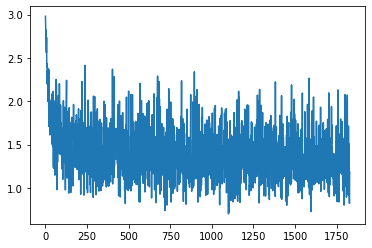

In [9]:
# train and plot
history = train(n_epochs, train_loader, model, optimizer, loss_fn)
plt.plot(history["loss"])

In [10]:
def label2image(pred):
    colormap = torch.tensor(VOC_COLORMAP,device=device,dtype=int)
    x = pred.long()
    return (colormap[x,:]).data.cpu().numpy()


In [11]:
img, label = val_dataset[100]
#print(img.shape)
#print(label.shape)
pred = model(img.unsqueeze(0).float())

#print(pred.shape)

softm = F.softmax(pred, dim=1)
values, indexes = torch.max(softm, dim=1)

#print (values.shape)
#print (indexes.shape)
#print (np.unique(indexes.detach().cpu().numpy()))
indexes = indexes.squeeze(0)


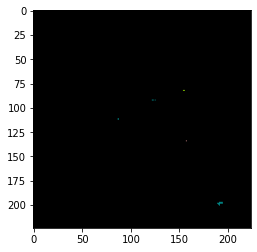

In [12]:
#rgb = decode_segmap(indexes.cpu())
rgb = label2image(indexes)
plt.imshow(rgb); plt.show()

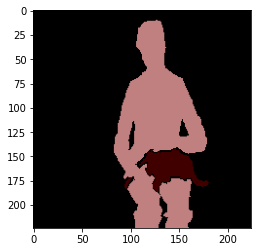

In [13]:
plt.imshow(img.cpu().permute(1,2,0))
plt.imshow(label2image(label))